### Check system executable path if import not working in Jupyter, but works at conda env

Reference: 
* https://stackoverflow.com/questions/39604271/conda-environments-not-showing-up-in-jupyter-notebook

import sys

print(sys.executable)

### Building A Flexible Configuration System and Experimentation Framework

Detectron2 provides a key-value based config system that can be used to obtain standard, common behaviors.

This system uses YAML and yacs. Yaml is a very limited language, so we do not expect all features in detectron2 to be available through configs. If you need something that’s not available in the config space, please write code using detectron2’s API.

Reference:
* https://detectron2.readthedocs.io/en/latest/tutorials/configs.html
* https://julienbeaulieu.github.io/2020/03/16/building-a-flexible-configuration-system-for-deep-learning-models/
* https://github.com/rbgirshick/yacs

Journey towards config.yaml file - Use YACS to define all default model configurations in one file

* Config file and pre-trained model weight - https://github.com/Layout-Parser/layout-parser/tree/master/src/layoutparser/models/detectron2



In [1]:
import torch
import numpy as np
import json
import os
import copy
import itertools
import os
import random
import torch
import detectron2
import pandas as pd
from detectron2.data import detection_utils as utils
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
setup_logger()

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.empty_cache()

/home/aghoshchowdh/.conda/envs/env_mde/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def custom_dataset(df, dir_image):

    dataset_dicts = []

    for image_id, image_name in enumerate(df.image_id.unique()):

        record = {}
        image_df = df[df['image_id'] == image_name]
        file_name = image_df['file_name'].astype(str).unique()
        file_name = file_name[0]
        img_path = os.path.join(dir_image, 'images/' + file_name)

        record['file_name'] = img_path
        record['image_id'] = image_df['image_id']
        record['height'] = int(image_df['height'].values[0])
        record['width'] = int(image_df['width'].values[0])

        objs = []
        for _, row in image_df.iterrows():

            x_min = int(row.xmin)
            y_min = int(row.ymin)
            x_max = int(row.xmax)
            y_max = int(row.ymax)
            label = str(row.label)

            if (label.lower() == 'table'):
                category_id = 0
            
            obj = {
                "bbox": [x_min, y_min, x_max, y_max],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": category_id,
                "iscrowd": 0

            }

            objs.append(obj)

        record['annotations'] = objs
        dataset_dicts.append(record)

    return dataset_dicts

def register_dataset(df, dataset_label, image_dir):

    # Register dataset
    DatasetCatalog.register(
        dataset_label, lambda d=df: custom_dataset(df, image_dir))
    MetadataCatalog.get(dataset_label).set(thing_classes=["Table"])
    return MetadataCatalog.get(dataset_label), dataset_label

In [3]:
TEST_DIR = '../data/test2021'
test_df = pd.read_csv('../data/annotations/diplast2021_test.csv')
_, test_dataset = register_dataset(test_df, dataset_label='test_dataset', image_dir=TEST_DIR)

UOS_MODEL_USE = 1

if UOS_MODEL_USE == 1:
    UOS_MODEL = '../diplastmodel/uos_dip_config.yaml'
    UOS_WEIGHT_PATH = '../diplastmodel/model_final.pth'
        
elif UOS_MODEL_USE == 2:
    UOS_MODEL = ''
    UOS_WEIGHT_PATH = ''

In [6]:
DatasetCatalog.clear()
    
# Dataset for testing and evaluation
register_coco_instances("val_coco", {}, "../data/annotations/instances_val2021.json", "../data/val2021/images")
register_coco_instances("test_coco", {}, "../data/annotations/instances_test2021.json", "../data/test2021/images")
    
# Testing and Evaluation Setup
cfg = get_cfg()
cfg.merge_from_file(UOS_MODEL)
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.WEIGHTS = UOS_WEIGHT_PATH
cfg.DATASETS.TEST = (test_dataset,)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set the testing threshold for this model
    
cfg.OUTPUT_DIR = "DiPlast"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [7]:
from detectron2.modeling import build_model
chk_model = build_model(cfg)  # returns a torch.nn.Module
print(chk_model)

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [5]:
# Predictor
predictor = DefaultPredictor(cfg)
    
# Evaluate on Val Dataset    
#evaluator = COCOEvaluator("val_cocodp", ("bbox",), False, output_dir="./output/")
evaluator = COCOEvaluator("val_coco")
val_loader = build_detection_test_loader(cfg, "val_coco")
print("----- Val Evaluator -----")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/09 22:29:16 d2.data.datasets.coco]: Loaded 30 images in COCO format from ../data/annotations/instances_val2021.json
[03/09 22:29:16 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Table    | 53           |
|            |              |
[03/09 22:29:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/09 22:29:16 d2.data.common]: Serializing 30 elements to byte tensors and concatenating them all ...
[03/09 22:29:16 d2.data.common]: Serialized dataset takes 0.01 MiB
----- Val Evaluator -----
[03/09 22:29:16 d2.evaluation.evaluator]: Start inference on 30 batches
[03/09 22:29:26 d2.evaluation.evaluator]: Inference done 11/30. Dataloading: 0.7173 s/iter. Inference: 0.0698 s/iter. Eval: 0.0029 s/iter. Total: 0.7899 s/iter. ETA=0:00:15
[03/09 22:29:32 d2.evaluation.evaluator]: Inference done 

In [6]:
# Evaluate on Test Dataset
test_evaluator = COCOEvaluator("test_coco")
test_loader = build_detection_test_loader(cfg, "test_coco")
print("----- Test Evaluator -----")
print(inference_on_dataset(predictor.model, test_loader, test_evaluator))

[03/09 22:29:40 d2.data.datasets.coco]: Loaded 7 images in COCO format from ../data/annotations/instances_test2021.json
[03/09 22:29:40 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Table    | 13           |
|            |              |
[03/09 22:29:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/09 22:29:40 d2.data.common]: Serializing 7 elements to byte tensors and concatenating them all ...
[03/09 22:29:40 d2.data.common]: Serialized dataset takes 0.00 MiB
----- Test Evaluator -----
[03/09 22:29:40 d2.evaluation.evaluator]: Start inference on 7 batches
[03/09 22:29:47 d2.evaluation.evaluator]: Total inference time: 0:00:01.038892 (0.519446 s / iter per device, on 1 devices)
[03/09 22:29:47 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.060896 s / iter per

In [7]:
dataset_dicts = DatasetCatalog.get("test_coco")

[03/09 22:29:47 d2.data.datasets.coco]: Loaded 7 images in COCO format from ../data/annotations/instances_test2021.json


In [8]:
dip_test_metadata = MetadataCatalog.get("test_coco")#.thing_colors = [(102, 255, 102), (102, 255, 255), (102, 102, 255)]

In [9]:
import random
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

tensor([0, 0], device='cuda:0')
Boxes(tensor([[ 298.6918, 2490.2002, 4015.6152, 4981.0796],
        [ 314.5208, 1611.6434, 3824.0532, 2537.7166]], device='cuda:0'))


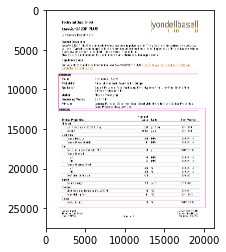

In [10]:
img_path = '../data/test2021/images/114_0.jpg'
im = cv2.imread(img_path)
outputs = predictor(im)
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
#v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]))
v = Visualizer(im[:, :, ::-1], metadata=dip_test_metadata, scale=5)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])

tensor([0], device='cuda:0')
Boxes(tensor([[ 289.6739,  157.2062, 4009.9680, 1100.0154]], device='cuda:0'))


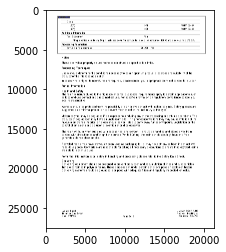

In [12]:
img_path = '../data/test2021/images/114_1.jpg'
im = cv2.imread(img_path)
outputs = predictor(im)
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
#v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]))
v = Visualizer(im[:, :, ::-1], metadata=dip_test_metadata, scale=5)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])

tensor([0, 0], device='cuda:0')
Boxes(tensor([[ 245.0212, 2134.1897, 3990.4531, 4211.4819],
        [ 327.9510, 1510.3218, 3821.4636, 2166.2598]], device='cuda:0'))


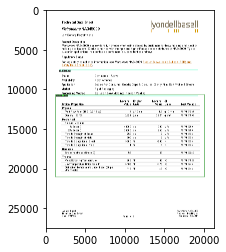

In [13]:
img_path = '../data/test2021/images/115_0.jpg'
im = cv2.imread(img_path)
outputs = predictor(im)
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
#v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]))
v = Visualizer(im[:, :, ::-1], metadata=dip_test_metadata, scale=5)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])

tensor([0, 0], device='cuda:0')
Boxes(tensor([[ 286.5822, 2183.3242, 3997.7090, 4860.2598],
        [ 323.0932, 1509.4750, 3843.6003, 2242.8538]], device='cuda:0'))


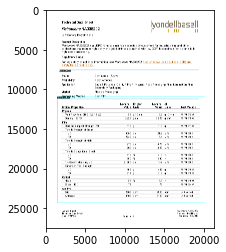

In [14]:
img_path = '../data/test2021/images/90_0.jpg'
im = cv2.imread(img_path)
outputs = predictor(im)
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
#v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]))
v = Visualizer(im[:, :, ::-1], metadata=dip_test_metadata, scale=5)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])

tensor([0, 0], device='cuda:0')
Boxes(tensor([[ 286.2797, 2171.1177, 3999.9402, 5017.8237],
        [ 328.8392, 1514.9161, 3868.3704, 2248.0588]], device='cuda:0'))


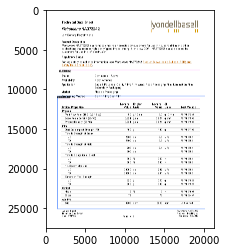

In [15]:
img_path = '../data/test2021/images/91_0.jpg'
im = cv2.imread(img_path)
outputs = predictor(im)
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
#v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]))
v = Visualizer(im[:, :, ::-1], metadata=dip_test_metadata, scale=5)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])

tensor([0], device='cuda:0')
Boxes(tensor([[ 340.6462,  392.3363, 2594.4741,  896.8907]], device='cuda:0'))


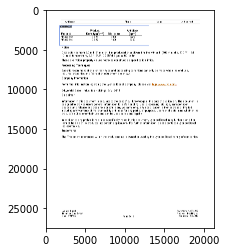

In [16]:
img_path = '../data/test2021/images/91_1.jpg'
im = cv2.imread(img_path)
outputs = predictor(im)
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
#v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]))
v = Visualizer(im[:, :, ::-1], metadata=dip_test_metadata, scale=5)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])

tensor([0, 0], device='cuda:0')
Boxes(tensor([[ 289.7253, 2146.6394, 3984.0610, 4917.5923],
        [ 305.4342, 1540.5791, 2010.6963, 2165.3245]], device='cuda:0'))


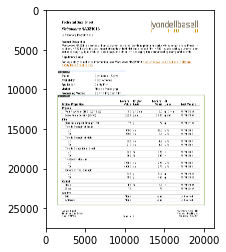

In [17]:
img_path = '../data/test2021/images/92_0.jpg'
im = cv2.imread(img_path)
outputs = predictor(im)
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
#v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]))
v = Visualizer(im[:, :, ::-1], metadata=dip_test_metadata, scale=5)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])